# Scoring of MCQ and FCQ from Amy's data
We will read in raw response data, combine with the WCQ and FCQ questions, and score each. This will result in a $\log(k)$ score for each participant for the WCQ and the FCQ.

WCQ = Lim & Bruce.

FCQ = Hendrickson et al (2015)

Information about use of `pm.Data` containers can be found here https://docs.pymc.io/notebooks/data_container.html. 

In [1]:
# Install Black autoformatter with: pip install nb-black
%load_ext lab_black

import pymc3 as pm

import numpy as np
import pandas as pd

# plotting
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14})

# Define options

In [2]:
SEED = 12345

# Define sampler options
sample_options = {
    "tune": 2000,
    "draws": 2000,
    "chains": 2,
    "cores": 2,
    "nuts_kwargs": {"target_accept": 0.95},
    "random_seed": SEED,
}

# Define plotting functions

In [3]:
def plot_discount_func(ax, data, trace):
    delays = np.linspace(0, np.max(data.DB.values), 1000)

    # plot posterior mean
    k = np.exp(np.mean(trace["logk"]))
    ax.plot(delays, discount_function(delays, k), lw=4)

    # plot 95% region
    p = np.percentile(np.exp(trace["logk"]), [5 / 2, 100 - (5 / 2)])
    ax.fill_between(
        delays,
        discount_function(delays, p[0]),
        discount_function(delays, p[1]),
        alpha=0.2,
    )

In [4]:
def plot_data(data, ax=None):

    if ax is None:
        ax = plt.gca()

    D = data["R"] == 1
    I = data["R"] == 0

    if np.sum(D) > 0:
        ax.scatter(
            x=data["DB"][D],
            y=data["RA"][D] / data["RB"][D],
            c="k",
            edgecolors="k",
            label="chose delayed prospect",
        )
    if np.sum(I) > 0:
        ax.scatter(
            x=data["DB"][I],
            y=data["RA"][I] / data["RB"][I],
            c="w",
            edgecolors="k",
            label="chose immediate prospect",
        )

    ax.set(
        xlabel="DB", ylabel="RA/RB", ylim=[0, 1], xlim=[0, 1.05 * np.max(data["DB"])]
    )

In [5]:
def plot_questions(data, ax=None):

    if ax is None:
        ax = plt.gca()

    ax.scatter(x=data["DB"], y=data["RA"] / data["RB"])
    ax.set(
        xlabel="DB", ylabel="RA/RB", ylim=[0, 1], xlim=[0, 1.05 * np.max(data["DB"])]
    )

# Load raw data

In [6]:
data = pd.read_csv("../02 processed data/study2_processed.csv")

# Read in question values from WCQ and FCQ
We need the delay and reward values for the WCQ and the FCQ. We will read these in from `.csv` files.

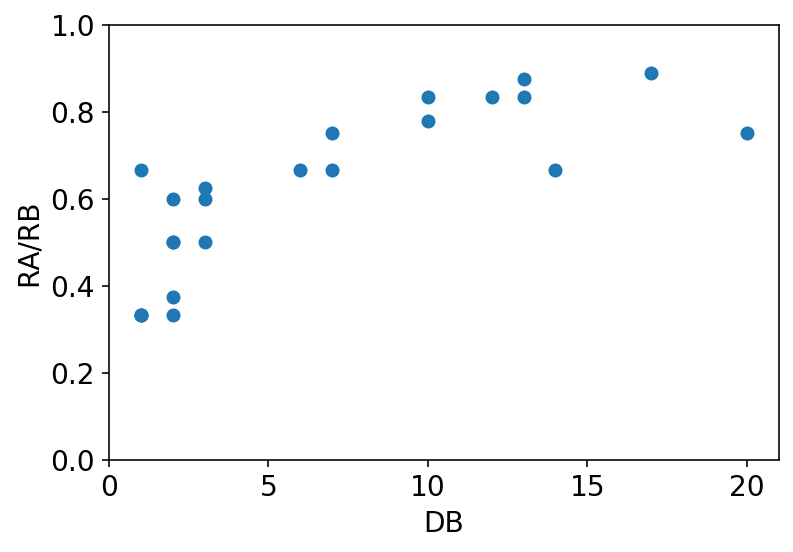

In [7]:
wcq = pd.read_csv("../discounting questions/robyn_wcq.csv")

# IMPORTANT: Ensure rows are sorted by `order`
wcq = wcq.sort_values(by="order")

plot_questions(wcq)

In [8]:
wcq

,i,order,RA,DA,RB,DB,mag,RA/RB,indifference k
0,NaN,1,7,NaN,8,13,NaN,0.875,0.0110
1,NaN,2,3,NaN,5,2,NaN,0.600,0.3333
2,NaN,3,7,NaN,9,10,NaN,0.778,0.0286
3,NaN,4,6,NaN,8,7,NaN,0.750,0.0476
4,NaN,5,5,NaN,6,13,NaN,0.833,0.0154
5,NaN,6,2,NaN,4,3,NaN,0.500,0.3333
6,NaN,7,3,NaN,4,20,NaN,0.750,0.0167
7,NaN,8,2,NaN,6,1,NaN,0.333,2.0000
8,NaN,9,2,NaN,3,14,NaN,0.667,0.0357
9,NaN,10,1,NaN,3,2,NaN,0.333,1.0000


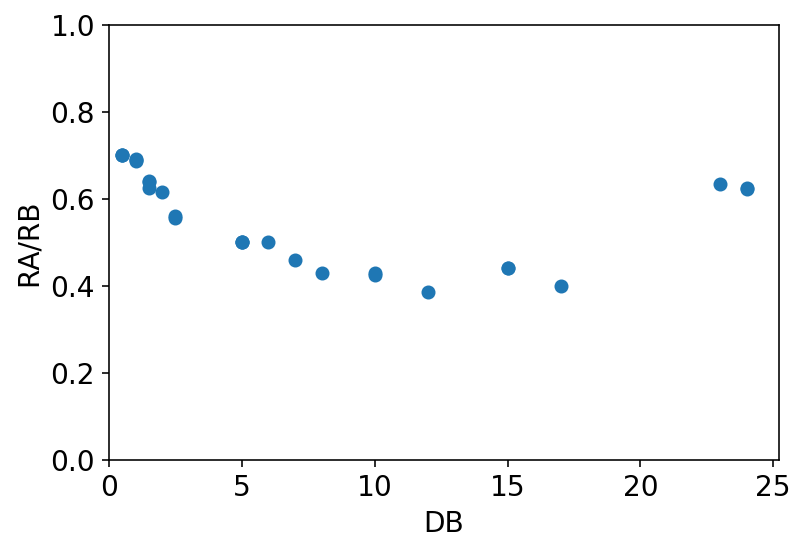

In [9]:
fcq = pd.read_csv("../discounting questions/robyn_fcq.csv")

# IMPORTANT: Ensure rows are sorted by `order`
fcq = fcq.sort_values(by="order")

plot_questions(fcq)

## Data extraction functions
These functions will get the responses from the raw data file, and combine them together with the MCQ or WCQ questions we imported.

In [10]:
def extract_WCQ_data(data, row):
    id = data.iloc[row, :].URN
    df = wcq
    df["R"] = (data.iloc[row, data.columns.str.contains("WCQ")] - 1).values
    # force to be numeric
    df = df.astype(float)
    return (id, df)

In [11]:
def extract_FCQ_data(data, row):
    id = data.iloc[row, :].URN
    df = fcq
    df["R"] = (data.iloc[row, data.columns.str.contains("FCQ")] - 1).values
    # force to be numeric
    df = df.astype(float)
    return (id, df)

In [12]:
# # in order to build the model we need some example data
# participant = 0
# temp_trial_data = extract_FCQ_data(data, participant)[1]
# temp_trial_data

# Build our Bayesian model
We will use the `pm.Data` class so that we can build one model only, then use it multiple times to fit data from each participant seperately. This should make things more efficient, avoiding building the same model hundreds of times.

In [13]:
def V(reward, delay, logk):
    """Calculate the present subjective value of a given prospect"""
    k = pm.math.exp(logk)
    return reward * discount_function(delay, k)


def discount_function(delay, k):
    """ Hyperbolic discount function """
    return 1 / (1.0 + (k * delay))


def Φ(VA, VB, ϵ=0.01):
    """Psychometric function which converts the decision variable (VB-VA)
    into a reponse probability. Output corresponds to probability of choosing
    the delayed reward (option B)."""
    return ϵ + (1.0 - 2.0 * ϵ) * (1 / (1 + pm.math.exp(-1.7 * (VB - VA))))

In [14]:
def build_model(data):
    with pm.Model() as model:

        # data nodes
        RA = pm.Data("RA", data.RA.values)
        RB = pm.Data("RB", data.RB.values)
        DB = pm.Data("DB", data.DB.values)
        R = pm.Data("R", data.R.values)

        # prior
        logk = pm.Normal("logk", mu=-3, sd=2)

        # response probability
        P = pm.Deterministic("P", Φ(RA, V(RB, DB, logk)))

        # likelihood
        response = pm.Bernoulli("response", p=P, observed=R)

    return model

In [15]:
def score_participant(data, plot=False):
    """Our core function to score a participant"""

    with model:
        # set the data
        pm.set_data({"RA": data.RA, "RB": data.RB, "DB": data.DB, "R": data.R})

        # do the sampling
        trace = pm.sample(**sample_options)

    logk_mean = np.mean(trace["logk"])

    if plot:
        fig, ax = plt.subplots(figsize=(6, 4))
        plot_data(data, ax=ax)
        plot_discount_func(ax, data, trace)
        plt.show()

    return logk_mean

# Score FCQ

In [16]:
# in order to build the model we need some example data
participant = 0
temp_trial_data = extract_FCQ_data(data, participant)[1]
temp_trial_data

# Now build the model at last
model = build_model(temp_trial_data)

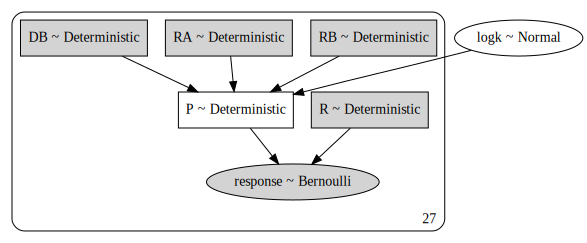

In [17]:
pm.model_to_graphviz(model)

In [18]:
n_participants = data.shape[0]

should_plot = False

pid = []
logk_fcq = []

for i in range(n_participants):
    id_num, fcq_trial_data = extract_FCQ_data(data, i)
    logk_fcq_value = score_participant(fcq_trial_data, plot=should_plot)
    logk_fcq.append(logk_fcq_value)
    pid.append(id_num)

results = pd.DataFrame({"URN": pid, "logk_fcq": logk_fcq})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2863.85draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1727.17draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1674.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2197.98draws/s]
The acceptance probabi

In [19]:
# results = pd.DataFrame({"URN": pid, "logk_fcq": logk_fcq})
# results = pd.DataFrame({"ID": pid, "logk_wcq": logk_wcq})
# results = pd.DataFrame({"ID": pid, "logk_wcq": logk_wcq, "logk_fcq": logk_fcq})

In [20]:
# merge with original data file
data = pd.merge(data, results, on="URN")

# Score WCQ

In [21]:
# in order to build the model we need some example data
participant = 0
temp_trial_data = extract_WCQ_data(data, participant)[1]
temp_trial_data

# Now build the model at last
model = build_model(temp_trial_data)

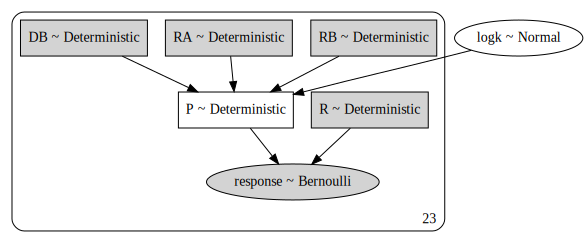

In [22]:
pm.model_to_graphviz(model)

In [23]:
n_participants = data.shape[0]

should_plot = False

pid = []
logk_wcq = []

for i in range(n_participants):
    id_num, wcq_trial_data = extract_WCQ_data(data, i)
    print(id_num)
    logk_wcq_value = score_participant(wcq_trial_data, plot=should_plot)
    logk_wcq.append(logk_wcq_value)
    pid.append(id_num)

results = pd.DataFrame({"URN": pid, "logk_wcq": logk_wcq})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53955464


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2751.43draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53955477


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2721.77draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53955913


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2477.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53955858


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2544.64draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53956174


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2441.73draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53956273


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2424.02draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53956268


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2566.88draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53956465


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2297.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53956193


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2245.73draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53956276


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2318.02draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53956911


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2824.62draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53956963


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2799.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53956904


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2225.37draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53957882


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2632.95draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53957686


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2504.64draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53957975


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2461.19draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53958393


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2573.71draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53959490


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2630.46draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53959621


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2433.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53959498


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2428.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53959406


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2230.55draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53959729


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2359.15draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53959819


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2480.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53960194


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2320.68draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53960242


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2438.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53959680


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2568.79draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53960328


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2391.69draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53960004


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2753.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53960355


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2832.45draws/s]
The acceptance probability does not match the target. It is 0.7410190735535208, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8949528491570652, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53960380


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2210.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53960622


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2467.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53960828


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2553.02draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53960827


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2672.36draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53960778


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2627.24draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53961126


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2595.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53961143


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2597.55draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53961071


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2481.13draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53961315


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2814.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53961855


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2688.06draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53961980


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2555.26draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53962076


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2525.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53962132


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2685.30draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53962087


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2403.55draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53962047


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2622.15draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53962544


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2723.25draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53962545


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2600.05draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53962693


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2409.63draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53962568


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2335.38draws/s]
The acceptance probability does not match the target. It is 0.8983565733881893, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53962537


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2500.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53962791


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2364.54draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53963082


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2253.03draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53962751


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2107.64draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53962934


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2598.64draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53963229


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2720.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53963762


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2542.70draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53964171


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2742.44draws/s]
The acceptance probability does not match the target. It is 0.9028841787901858, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53964081


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2479.72draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53964202


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2512.89draws/s]
The acceptance probability does not match the target. It is 0.8994965559869363, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53964550


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2558.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53965172


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2672.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53965326


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2452.99draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53965341


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2333.23draws/s]
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53965249


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2559.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53965323


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2695.21draws/s]
The acceptance probability does not match the target. It is 0.8808360797462217, but should be close to 0.95. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53965667


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2730.51draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53965782


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2420.90draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53965671


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2617.80draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53965780


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2565.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53965851


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2633.13draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53965915


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2784.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53966678


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2454.84draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53966955


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2665.50draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53966928


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2607.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53967155


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2604.52draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53967370


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2706.10draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53967321


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2610.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53968166


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2717.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53968229


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2726.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53969882


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2368.37draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53970167


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2430.90draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53971387


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2388.10draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53971583


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2303.26draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53972179


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2344.86draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53973160


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2440.95draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53977127


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2637.62draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53978418


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2422.55draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53978983


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2671.71draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53982792


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2631.26draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53983991


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2625.81draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53986582


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2790.67draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53986912


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2606.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53990616


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2723.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53997980


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2672.16draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-53999754


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2355.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54007985


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2733.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54011032


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2621.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54012079


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2525.12draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54013031


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2515.95draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54013548


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2364.23draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54015565


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2275.39draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54015611


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2640.12draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54015589


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2849.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54018414


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2413.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54019322


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2798.44draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54019636


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2433.42draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54020357


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2459.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54046681


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2658.17draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54048199


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2411.86draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54048499


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2117.81draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54086892


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2157.46draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54090450


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2359.56draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54090635


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1710.03draws/s]
The acceptance probability does not match the target. It is 0.8996293043692389, but should be close to 0.95. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54090906


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2163.07draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54091062


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1438.91draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54091707


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1727.93draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54091735


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2259.73draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54091983


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2490.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54094645


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2476.12draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54094596


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2253.89draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54095263


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2247.41draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54099539


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1583.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54103859


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1596.06draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54105655


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2043.05draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54108057


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2114.17draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54113450


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2280.50draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54114024


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1794.06draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54114008


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1687.39draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54131290


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1871.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54132713


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1977.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54134784


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2350.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54137101


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2084.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54137907


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1883.76draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54139064


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1955.86draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54140902


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2014.38draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54144037


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2540.38draws/s]
The acceptance probability does not match the target. It is 0.8808360797462217, but should be close to 0.95. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54144166


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1790.56draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54144316


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2244.73draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54145306


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2559.58draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54149061


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1989.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54151886


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2077.69draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54159308


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2408.51draws/s]
The acceptance probability does not match the target. It is 0.8808360797462217, but should be close to 0.95. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54183472


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2137.90draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54185861


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2202.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54189298


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2681.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54190238


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2158.50draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54190803


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2220.03draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54191089


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2127.89draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54191088


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2456.87draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54191648


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2014.60draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54192387


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2073.02draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54192643


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2441.55draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54192746


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2083.66draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54193053


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2043.12draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54193422


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2104.46draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54194845


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2242.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54195752


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2223.06draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54198824


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2302.47draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54203986


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2251.21draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54204835


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2029.02draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54211395


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1989.72draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54242163


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2277.14draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54243369


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2090.15draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54253943


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2098.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54281145


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2156.99draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54281359


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2234.62draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54281662


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2183.25draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54281653


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2187.22draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54282423


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2565.99draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54282975


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2144.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54283094


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2072.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54283799


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2176.39draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54283956


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2268.16draws/s]
The acceptance probability does not match the target. It is 0.8808360797462217, but should be close to 0.95. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54285099


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2186.28draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54288974


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2244.09draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54290490


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2414.33draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54290904


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2004.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54292255


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2232.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54294213


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2198.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54300184


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2225.24draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54304443


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2199.86draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54308050


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2135.01draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54308976


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2115.51draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54313912


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2270.24draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54318300


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2316.73draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54324154


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2708.95draws/s]
The acceptance probability does not match the target. It is 0.8909123669537763, but should be close to 0.95. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54349524


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2372.28draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54350677


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2217.05draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54357193


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2338.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54357745


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1833.57draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54357871


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2026.97draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54363817


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2350.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54365257


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2655.46draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54365594


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2372.00draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54365529


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2169.71draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54365444


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2516.05draws/s]
The acceptance probability does not match the target. It is 0.7974311632925938, but should be close to 0.95. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54366369


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2622.12draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54367865


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2306.38draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54379511


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2443.84draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54422720


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1964.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54423176


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2688.28draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54423479


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2214.47draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54423878


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2691.71draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54423765


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2186.18draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54424032


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2436.88draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54424160


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2299.76draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54424674


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2254.59draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54424581


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2534.48draws/s]
The acceptance probability does not match the target. It is 0.8890408186049427, but should be close to 0.95. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54424591


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2456.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54424882


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2634.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54424517


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2263.68draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54425056


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2229.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54424992


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2538.03draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54425332


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2364.70draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54425463


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2492.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54425545


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2467.82draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54425873


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2478.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54425648


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2245.87draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54426072


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1991.40draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54425883


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1993.90draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54425982


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2213.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54426173


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2518.86draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54423913


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2522.44draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54426523


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2306.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54426531


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2474.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54426572


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2491.11draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54426989


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2548.59draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54427235


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2354.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54427166


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2306.69draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54427391


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2452.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54427134


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2464.74draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54427686


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2441.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54427512


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2400.63draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54427526


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2288.95draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54428455


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2276.45draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54428199


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2302.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54427244


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2304.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54428897


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2313.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54428864


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2320.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54429712


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2574.40draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54429343


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2231.69draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54429752


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2428.10draws/s]
The acceptance probability does not match the target. It is 0.8915249067583969, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54429256


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:02<00:00, 2678.69draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54430357


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2477.05draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54430479


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2389.02draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54430308


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1947.57draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54430865


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2093.72draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54430652


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1969.68draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54430992


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2292.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54431151


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2113.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54431383


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2059.20draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54432130


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2166.62draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54432272


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2234.36draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54432924


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2444.68draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54432851


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2171.10draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54433155


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2521.05draws/s]
The acceptance probability does not match the target. It is 0.8808360797462217, but should be close to 0.95. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54433773


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2342.70draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54434126


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2244.78draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54434603


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2398.16draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54435428


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2186.40draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54435596


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2162.76draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54435479


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2017.99draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54435725


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2310.78draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54436548


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2194.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54436926


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2241.75draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54436511


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1751.67draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54437414


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2303.00draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54437619


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1806.09draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54438262


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2444.30draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54438392


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2415.49draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54437629


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2336.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54438961


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2096.69draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54439085


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1879.49draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54439540


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2335.95draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54439630


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2265.48draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54439638


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2234.93draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54440009


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2379.25draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54440344


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2054.92draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54440436


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2426.88draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54440828


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2414.91draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54440919


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2070.66draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54441623


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2202.63draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54441655


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2235.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54441905


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2100.15draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54441991


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2217.28draws/s]
The acceptance probability does not match the target. It is 0.7599141849786788, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54442032


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2167.22draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54442795


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2233.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54442940


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2251.70draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54443072


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2468.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54443531


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2261.56draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54444660


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2444.84draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54444589


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2643.09draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54446224


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2168.09draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54451721


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2247.16draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54454279


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2455.32draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54454476


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2474.03draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54455274


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2509.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54456734


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2224.68draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54459306


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2466.00draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54460298


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1914.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54460321


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2169.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54461176


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2372.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54461775


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2198.50draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54461024


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2289.36draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54468558


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2173.29draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54468555


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2403.06draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54471479


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2607.28draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54472515


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2522.01draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54473481


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2217.54draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54473260


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2447.55draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54473928


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2502.47draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54474310


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2425.85draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54474125


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2482.94draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54475073


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2554.21draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54476058


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2157.17draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54475882


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2061.16draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54472377


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2374.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54477523


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2197.80draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54477625


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2372.76draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54478004


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2448.40draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54477034


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2423.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54478376


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2186.99draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54478877


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2555.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54479514


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2421.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54479422


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2465.21draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54477335


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2234.79draws/s]
The acceptance probability does not match the target. It is 0.90421444385982, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54480565


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2226.68draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54479476


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2430.26draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54480533


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2108.12draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54481574


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2350.38draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54482269


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2458.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54478339


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2416.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54482523


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2088.91draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54483213


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2289.59draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54483135


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2310.28draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54483992


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2415.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54485527


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1956.60draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54486575


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2225.74draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54486883


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2435.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54487601


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2409.59draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54489550


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2430.18draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54493695


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2057.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54494211


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2329.84draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54498704


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2535.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54506075


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2365.37draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54508695


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2413.94draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54527609


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2246.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54557646


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2464.11draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54591794


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2416.52draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54593386


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2313.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54593579


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2215.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54595505


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2240.68draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54599793


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2181.71draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54602960


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2384.13draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54603983


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2392.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54606826


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2065.15draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54609586


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2214.02draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54614153


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2168.21draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54616716


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2230.64draws/s]
The acceptance probability does not match the target. It is 0.7599141849786788, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54625326


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2221.18draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54630874


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2231.08draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54635144


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2295.88draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54643679


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2285.99draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54732886


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2292.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54733113


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2453.41draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54733703


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2274.30draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54733606


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2352.16draws/s]
The acceptance probability does not match the target. It is 0.8543010984323275, but should be close to 0.95. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54734143


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2428.84draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54733652


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2315.02draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54734330


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2406.35draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54734487


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2435.07draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54734664


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2434.72draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54735446


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2478.37draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54735391


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2408.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54735743


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2389.21draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54736649


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2156.25draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54737358


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2226.92draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54738310


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2228.33draws/s]
The acceptance probability does not match the target. It is 0.8918986299891415, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54738844


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2496.38draws/s]
The acceptance probability does not match the target. It is 0.8996293043692389, but should be close to 0.95. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54739135


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2258.77draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54738991


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2395.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54739268


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2161.68draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54739698


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2242.17draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54742020


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1642.02draws/s]
The acceptance probability does not match the target. It is 0.7599141849786788, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54744091


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2142.64draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54744763


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2368.51draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54745766


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2374.53draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54748066


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2364.70draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54752708


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2095.31draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54755107


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2513.07draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54755038


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2559.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54755743


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2375.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54755767


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2484.99draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54756148


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1997.28draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54758797


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2358.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54761025


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2367.47draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54761888


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2419.74draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54767697


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2303.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54767990


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2225.64draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54772379


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2169.49draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54773817


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2195.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54774590


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1910.78draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54775482


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2224.66draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54781090


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2367.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54782153


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2201.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54785536


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2344.94draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54788489


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2185.25draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54788792


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2397.47draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54796704


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2211.76draws/s]
The acceptance probability does not match the target. It is 0.8981035635883693, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54797579


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2250.88draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54815098


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2148.52draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54816313


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1953.15draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54817808


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1961.05draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54820090


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2368.75draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54819809


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2287.06draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54820829


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2273.62draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54821968


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2296.97draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54822091


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2480.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54822753


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2167.20draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54823066


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2169.67draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54823528


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2412.67draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54823985


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2402.64draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54825031


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2370.30draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54825474


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2201.72draws/s]
The acceptance probability does not match the target. It is 0.9067624502867934, but should be close to 0.95. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54825781


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2295.70draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54825884


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2362.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54826837


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2177.01draws/s]
The acceptance probability does not match the target. It is 0.8918986299891415, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54827825


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2237.74draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54829412


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2291.66draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54829918


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2268.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54830626


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2250.31draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54831106


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2260.62draws/s]
The acceptance probability does not match the target. It is 0.8918986299891415, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54831756


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2429.86draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54838882


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2452.19draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54846113


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2334.54draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54851374


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2193.17draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54940044


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2318.55draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54967941


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2263.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-54999442


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2176.11draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-55218530


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2085.41draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


542031-542022-55378674


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logk]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1874.03draws/s]


In [24]:
# merge with original data file
data = pd.merge(data, results, on="URN")

## Wrap up

In [25]:
# remove raw data columns, no longer needed
data = data[data.columns.drop(list(data.filter(regex="WCQ")))]
data = data[data.columns.drop(list(data.filter(regex="FCQ")))]

In [26]:
# export
data.to_csv("study2_final_data.csv", index=False)

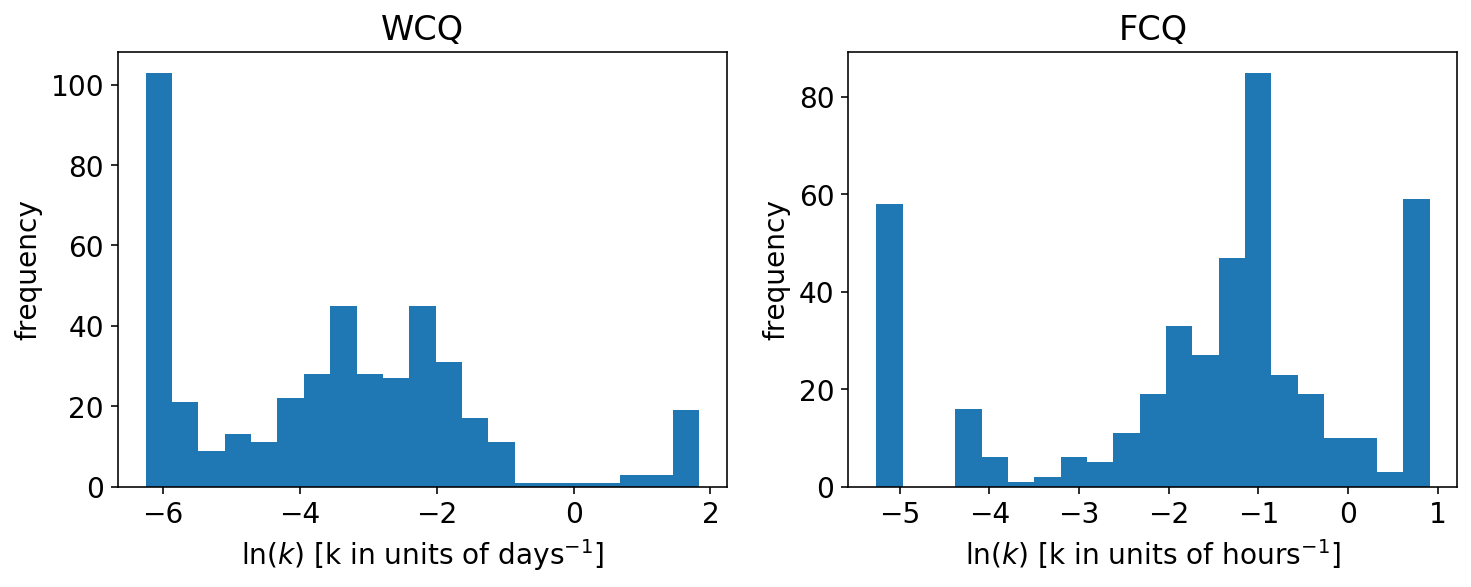

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=False)

bins = 21

ax[0].hist(logk_wcq, bins)
ax[0].set(
    xlabel="$\ln(k)$ [k in units of days$^{-1}$]", ylabel="frequency", title="WCQ"
)

ax[1].hist(logk_fcq, bins)
ax[1].set(
    xlabel="$\ln(k)$ [k in units of hours$^{-1}$]", ylabel="frequency", title="FCQ"
)

# increased space between rows
plt.subplots_adjust(hspace=0.4)

plt.savefig("../study2_fit_histograms.pdf", bbox_inches="tight", dpi=300)